# Automatic product categorization 
By Robin de Heer

## Step 1: Imports & style

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import seaborn as sns

plt.style.use('ggplot')

## Step 2: Data & lables

In [2]:
df = pd.read_csv('JC_Penney-Subset.csv')
print(f'#documents: {len(df)}')
print(f'Columns: {df.columns}')

#documents: 1292
Columns: Index(['uniq_id', 'sku', 'name_title', 'description', 'list_price',
       'sale_price', 'category', 'category_tree', 'average_product_rating',
       'product_url', 'product_image_urls', 'brand', 'total_number_reviews',
       'Reviews'],
      dtype='object')


Task is category classification: we will only need the columns 'name_title', 'description', 'category'. 'category_tree' could be used for hierarchical classification (e.g. Silla et al., 2009). 'brand' can be usefull, but is usually present in the title and is therefore omitted.

In [3]:
df = df[['name_title', 'description', 'category']]

Missing values?

In [4]:
for col in df.columns: 
    print(df[col].isna().sum(), col)

0 name_title
18 description
0 category


18 descriptions missing

Prep the data: 

In [5]:
df['X'] = df['name_title'] + ' ' + df['description']

In [6]:
nltk.download('stopwords')
sw = stopwords.words(['english'])
PS = PorterStemmer()

def prepr(doc): 
    doc = ' '.join([PS.stem(word) for word in re.findall('\w+', doc) if word not in sw and word is not '' and not any(map(str.isdigit, word))]) 
    return doc

df['X_prepr'] = df['X'].astype(str).map(prepr)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Visualize the data:

In [7]:
def pp(title, iterable): 
    return f'{title}: \nmean: {np.mean(iterable)} \nstd: {np.std(iterable)} \nmax: {max(iterable)} \nmin: {min(iterable)}'

Document lengths: 
mean: 37.79179566563467 
std: 16.589260230037954 
max: 187 
min: 1


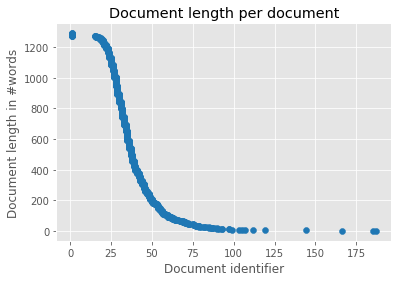

In [8]:
doclens = df['X_prepr'].str.split().str.len()
plt.scatter(sorted(doclens, reverse=True), np.arange(len(doclens)), color='tab:blue')
plt.xlabel('Document identifier')
plt.ylabel('Document length in #words')
plt.title('Document length per document')
print(pp('Document lengths', doclens))

Some documents contain more words than others. Relevant when determining the number of words to be considered when using word embeddings. 

Visualize the label distributions: 

Documents per category: 
mean: 86.13333333333334 
std: 41.677918480760155 
max: 198 
min: 45


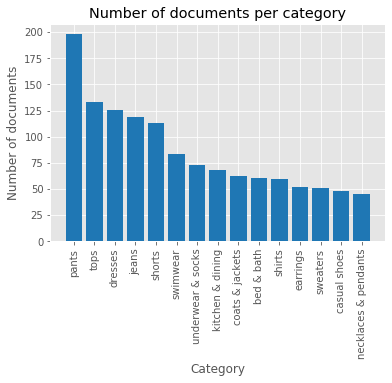

In [9]:
counts = df['category'].value_counts()
plt.bar(counts.index, counts.values, color='tab:blue')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Number of documents per category')
print(pp('Documents per category', counts))


Not uniformly distributed, will tackle this issue using class_weights = 'balanced'

In [10]:
X, y = df['X_prepr'].__array__(), df['category'].__array__()
tfidf = TfidfVectorizer()
feat = tfidf.fit_transform(X, y)
print(len(tfidf.vocabulary_))

3492


Only 3492 different words exist. Will use the full vocabulary, no TfidfVectorizer tweaking. 

Visualize most imporant tfidf features: 

Text(0, 0.5, 'Component 2')

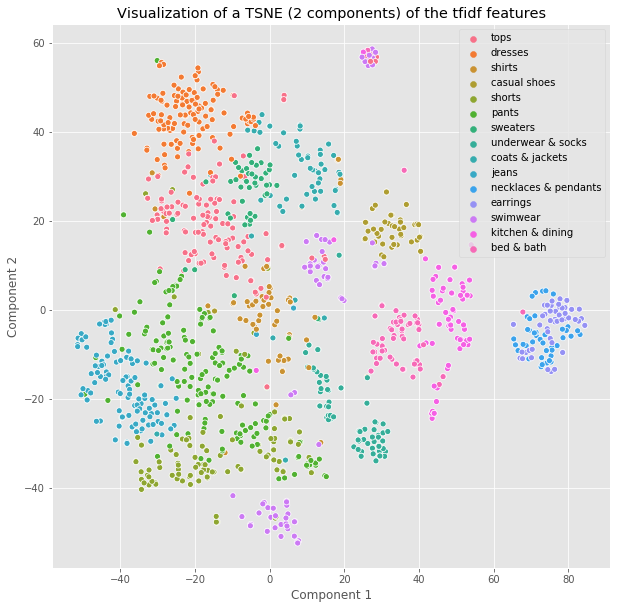

In [11]:
x_emb = TSNE().fit_transform(feat, y)
plt.figure(figsize=(10,10))
plt.title('Visualization of a TSNE (2 components) of the tfidf features')
sns.scatterplot(x_emb[:, 0], x_emb[:, 1], hue=y) # sns scatter is much nicer
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Colors are grouped okay (based on the 2 best tfidf features), basic classifier will do the trick. 

## Classification

Perform gridsearch and crossvalidate classifiers

In [12]:
param_grid = [{ 
        'clf': [SGDClassifier(class_weight='balanced')],
        'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'] # hinge for svm, log for logreg
    }, 
    {
        'clf': [LogisticRegression(class_weight='balanced')], # explicitly test logreg as well
        'clf__C': [.9, .95, 1, 1.05, 1.1], 
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }, 
    {
        'clf': [DecisionTreeClassifier(class_weight='balanced')], 
        'clf__criterion': ['gini', 'entropy']
    }, 
    {
        'clf': [RandomForestClassifier(class_weight='balanced')], 
        'clf__n_estimators': [75, 100, 200, 500], 
        'clf__criterion': ['gini', 'entropy']
    }
]

In [13]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SGDClassifier())])
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print('To export: ', search.best_estimator_)

Best parameter (CV score=0.933):
{'clf': SGDClassifier(class_weight='balanced', loss='log'), 'clf__loss': 'log'}
To export:  Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(class_weight='balanced', loss='log'))])


In [14]:
mean_scores = np.array(search.cv_results_['mean_test_score'])
print(sum(mean_scores < .6))

0


Every classifier functioned properly

Train an example pipeline to visualize performance

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe = search.best_estimator_ 
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

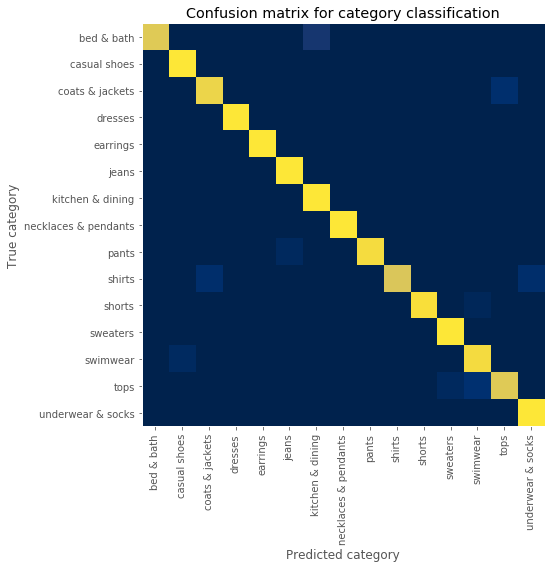

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix(y_test, y_pred, normalize='true'), cmap='cividis')
plt.grid(None) # ggplot correction for confusion matrices
plt.xticks(np.arange(len(pipe.classes_)), pipe.classes_, rotation=90)
plt.yticks(np.arange(len(pipe.classes_)), pipe.classes_)
plt.ylim(len(pipe.classes_)-.5, -.5) # correction for strange cropping of top and bottom
plt.title('Confusion matrix for category classification')
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.tight_layout()

In [17]:
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

          bed & bath       1.00      0.88      0.94        17
        casual shoes       0.90      1.00      0.95         9
     coats & jackets       0.93      0.93      0.93        14
             dresses       1.00      1.00      1.00        39
            earrings       1.00      1.00      1.00        11
               jeans       0.93      1.00      0.96        26
    kitchen & dining       0.89      1.00      0.94        17
necklaces & pendants       1.00      1.00      1.00        11
               pants       1.00      0.96      0.98        50
              shirts       1.00      0.87      0.93        15
              shorts       1.00      0.97      0.98        32
            sweaters       0.93      1.00      0.96        13
            swimwear       0.88      0.96      0.92        23
                tops       0.96      0.88      0.92        25
   underwear & socks       0.95      1.00      0.98        21

      

All categories are adequately represented in the classifier. No strange drops in performance for any category. 